In [23]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import yfinance as yf

In [24]:
#Extracting DataFrame From Web :
import pandas_datareader as web

In [25]:
#Stock Symbol Used : Alphabet A Inc - > Google 
# From 1 july 2021 to 30 June 2023
#This data is full collection of all stock features from Google's Stock Market
df_g = yf.download('GOOGL', start='2021-07-01', end='2023-07-01')

[*********************100%%**********************]  1 of 1 completed


In [26]:
df_g.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 503 entries, 2021-07-01 to 2023-06-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       503 non-null    float64
 1   High       503 non-null    float64
 2   Low        503 non-null    float64
 3   Close      503 non-null    float64
 4   Adj Close  503 non-null    float64
 5   Volume     503 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 27.5 KB


In [27]:
df_g.describe()

,Open,High,Low,Close,Adj Close,Volume
count,503.000000,503.000000,503.000000,503.000000,503.000000,5.030000e+02
mean,118.874019,120.348290,117.455635,118.917678,118.917678,3.360941e+07
std,18.626035,18.522343,18.487173,18.496912,18.496912,1.375082e+07
min,85.400002,86.519997,83.339996,83.430000,83.430000,9.701400e+06
25%,102.395000,104.125000,101.385002,102.905003,102.905003,2.502870e+07
50%,117.089996,119.189499,116.110001,118.080002,118.080002,3.077400e+07
75%,136.280998,137.716248,135.263748,136.364006,136.364006,3.808445e+07
max,151.250000,151.546494,148.899002,149.838501,149.838501,1.232000e+08


In [28]:

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [29]:
df_g
#Indicating Number Of days and features -> 123 days and 6 stock features

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-07-01,121.724998,122.586998,121.531502,122.444504,122.444504,18110000
2021-07-02,123.150002,125.403999,123.059502,125.257500,125.257500,25982000
2021-07-06,125.648499,126.428001,124.582497,126.190002,126.190002,26404000
2021-07-07,127.162003,127.283997,126.153000,126.473999,126.473999,24060000
2021-07-08,124.026001,125.595497,124.022003,125.043999,125.043999,23790000
...,...,...,...,...,...,...
2023-06-26,120.760002,122.000000,118.269997,118.339996,118.339996,33969900
2023-06-27,117.080002,119.080002,116.099998,118.330002,118.330002,39535900
2023-06-28,117.089996,120.389999,116.849998,120.180000,120.180000,27091400


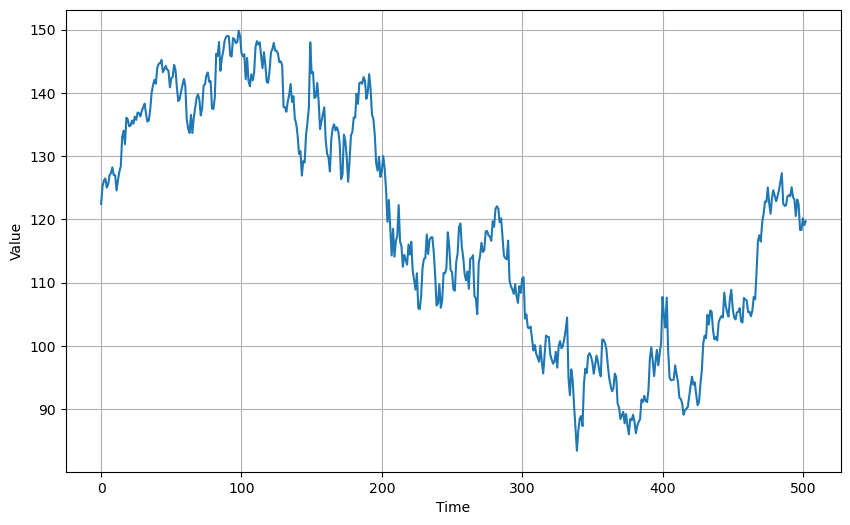

In [30]:

temps=[]
time_step=[]

step=0
for row in range(503):
      time_step.append(step)
      step = step + 1

ds = np.array(df_g['Close'].values)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, ds)



In [31]:
ds_g = ds.reshape(-1,1)
print(ds_g.shape)

(503, 1)


In [32]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
series = scaler.fit_transform(ds_g)

In [33]:
split_time = 2500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [34]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [35]:
def windowed_valid_dataset(series, window_size, batch_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [36]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [37]:
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [38]:
print(train_set)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))>


In [39]:
#Checking The Batches And their corresponding or respective label ,x and y 
for x,y in train_set:
    print("x :",x.numpy())
    print("y :",y.numpy())

x : [[[0.91878308]
  [0.87782445]
  [0.8760474 ]
  [0.90413882]
  [0.94844775]
  [0.95599965]
  [0.97090724]
  [0.95254366]
  [0.95206183]
  [0.94521785]
  [0.92491178]
  [0.92701235]
  [0.9180979 ]
  [0.81834393]
  [0.81792988]
  [0.8069298 ]
  [0.8318136 ]
  [0.84787326]
  [0.87338963]
  [0.83057146]
  [0.84402597]
  [0.79158542]
  [0.77831151]
  [0.75107094]
  [0.70655866]
  [0.71337254]
  [0.65511187]
  [0.68971594]
  [0.68628269]
  [0.75172602]]

 [[0.77831151]
  [0.75107094]
  [0.70655866]
  [0.71337254]
  [0.65511187]
  [0.68971594]
  [0.68628269]
  [0.75172602]
  [0.78112736]
  [0.81637134]
  [0.97231528]
  [0.8983789 ]
  [0.90143579]
  [0.83981724]
  [0.84279876]
  [0.87582153]
  [0.83106823]
  [0.76575288]
  [0.78447789]
  [0.80077858]
  [0.81778697]
  [0.73949872]
  [0.70733414]
  [0.69845737]
  [0.66494495]
  [0.74178747]
  [0.76841823]
  [0.77741563]
  [0.76242487]
  [0.77010476]]

 [[0.09983657]
  [0.10435411]
  [0.12904974]
  [0.15389598]
  [0.17618222]
  [0.15705821]
  

In [40]:
x[0],y[0]   #very First Set of batch of 64 values window and its respective 65th next value or label of first set..

(<tf.Tensor: shape=(30, 1), dtype=float64, numpy=
 array([[0.51488133],
        [0.46847918],
        [0.50280465],
        [0.50775876],
        [0.50842888],
        [0.47291389],
        [0.41758959],
        [0.34577654],
        [0.35064034],
        [0.3965532 ],
        [0.34037059],
        [0.35708532],
        [0.42334939],
        [0.42249866],
        [0.43386007],
        [0.5201894 ],
        [0.4879421 ],
        [0.43032894],
        [0.4257211 ],
        [0.38448387],
        [0.3810883 ],
        [0.44923466],
        [0.46894596],
        [0.5323565 ],
        [0.54094731],
        [0.48557787],
        [0.46064133],
        [0.42048081],
        [0.40563331],
        [0.42686547]])>,
 <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.38549279]])>)

In [41]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True), 
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer='adam',
              metrics=["mse"])
history = model.fit(train_set,epochs=100)


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))>
(503, 1)


Epoch 1/100
2/2 [==============================] - 3s 174ms/step - loss: 11.8960 - mse: 205.0587
Epoch 2/100
2/2 [==============================] - 0s 76ms/step - loss: 8.9846 - mse: 114.5477
Epoch 3/100
2/2 [==============================] - 0s 80ms/step - loss: 1.6701 - mse: 5.7566
Epoch 4/100
2/2 [==============================] - 0s 83ms/step - loss: 3.1051 - mse: 15.5502
Epoch 5/100
2/2 [==============================] - 0s 82ms/step - loss: 1.1387 - mse: 4.0292
Epoch 6/100
2/2 [==============================] - 0s 85ms/step - loss: 1.5639 - mse: 5.4867
Epoch 7/100
2/2 [==============================] - 0s 85ms/step - loss: 0.2948 - mse: 0.6574
Epoch 8/100
2/2 [==============================] - 0s 84ms/step - loss: 0.2535 - mse: 0.5134
Epoch 9/100
2/2 [==============================] - 0s 93ms/step - loss: 0.2060 - mse: 0.4289
Epoch 10/100
2/2 [==============================] - 0s 110ms/step - loss: 0.1694 - mse: 0.3418
Epoch 11/100
2/2 [==============================] - 0s 110ms/

In [42]:
#plt.semilogx(history.history["lr"], history.history["loss"])
#plt.axis([1e-8, 1e-4, 0, 60])

In [43]:
window_size1 = 64
batch_size1 = 256

In [44]:
pd=model_forecast(model,series,window_size1)

14/14 [==============================] - 1s 16ms/step


In [45]:
pd.shape

(440, 64, 1)

In [46]:
pd=pd[split_time - window_size:-1, -1, 0]

In [47]:
pd.shape

(0,)

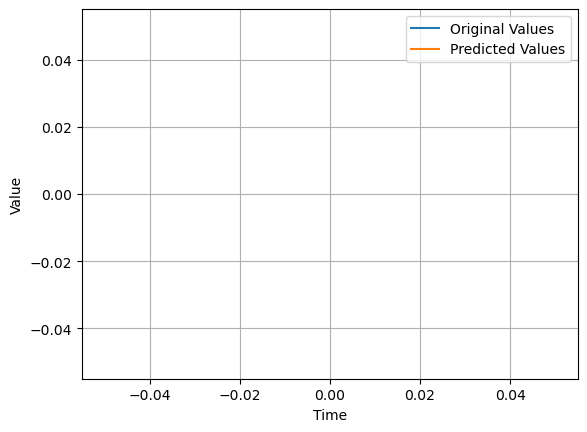

In [48]:
plot_series(time_valid, x_valid)
plot_series(time_valid,pd)
plt.legend(['Original Values','Predicted Values'])

In [49]:
rnn_forecast = model_forecast(model, series, window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

14/14 [==============================] - 0s 13ms/step


In [50]:
print(rnn_forecast.shape)
print(x_valid.shape)
y=np.array(x_valid)
print(x_valid.shape)

(0,)
(0, 1)
(0, 1)


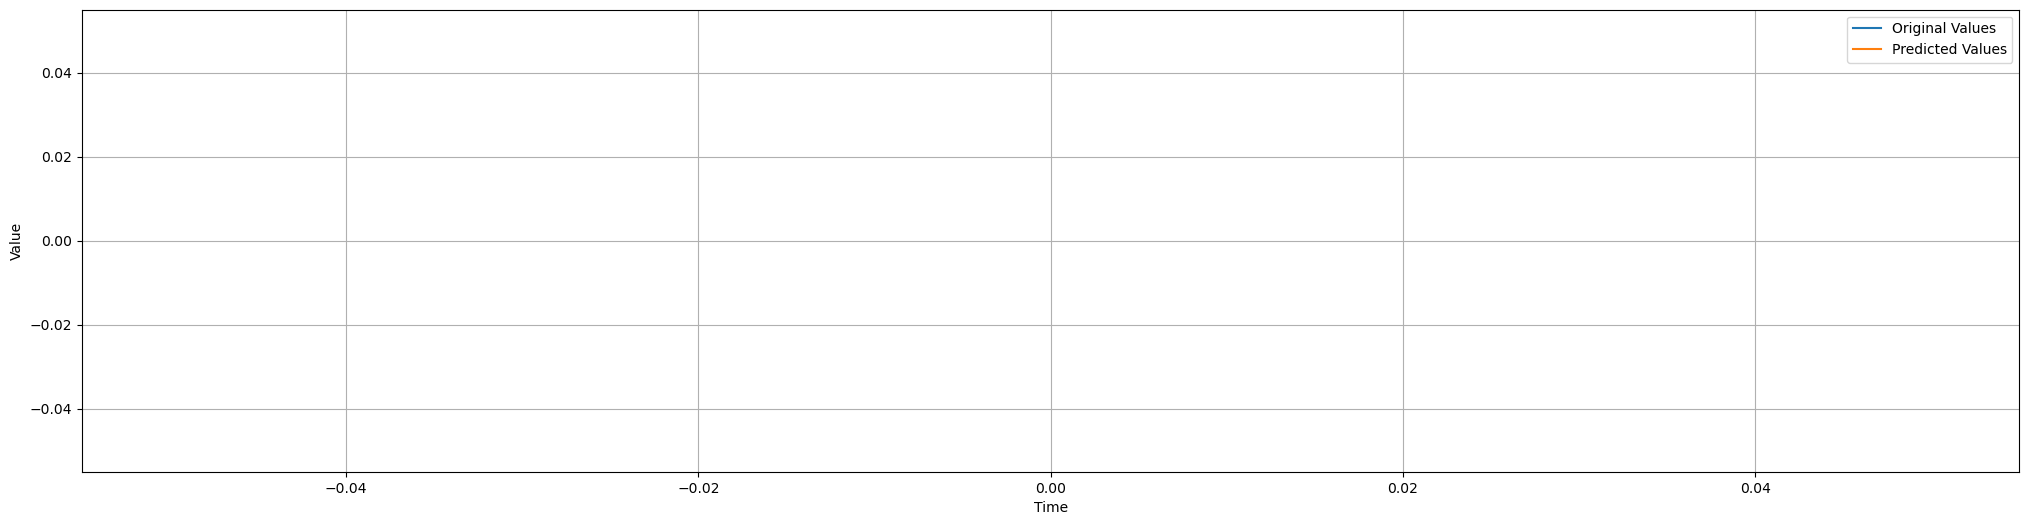

In [51]:
plt.figure(figsize=(25, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)
plt.legend(['Original Values','Predicted Values'])

In [52]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

array([], dtype=float32)

In [53]:
print(rnn_forecast)
print(x_valid)

[]
[]


In [54]:
#Beyond Future Forecasting :